In [1]:
import pandas as pd
import numpy as np

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
df = pd.read_csv("df.csv")
_s_idx = df[df.date == "2022-04-08 10:45:00"].index[0]
_seq = df[_s_idx:_s_idx+25][["i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]
_seq.i_m1sum /= 1000
_seq.power_consumption /= 1000
_seq

,i_m1sum,power_consumption,thermal_consumption_kwh,demand_price,feedin_price,kwh_eq_state
9285,1.246,0.197,0.000000,0.45,0.150000,67.500400
9286,1.017,0.063,0.000000,0.45,0.150000,66.922333
9287,1.115,0.089,0.000000,0.45,0.150000,67.144667
9288,0.845,0.324,0.000000,0.45,0.150000,67.989533
9289,0.615,0.075,0.000000,0.45,0.150000,68.389733
9290,0.560,0.055,0.000000,0.45,0.150000,68.478667
9291,0.551,0.043,0.000000,0.45,0.150000,68.656533
9292,0.534,0.074,0.000000,0.45,0.150000,69.723733
9293,0.505,0.065,0.000000,0.45,0.150000,68.612067
9294,0.399,0.062,0.000000,0.47,0.156667,70.657533


In [4]:
print(df.kwh_eq_state.max())

82.53013333333332


In [5]:
max_storage_tank = 82.53
optimum_storage = 75.00
gamma = 0.055

start_capacity = _seq.kwh_eq_state.to_list()[0]

In [6]:
def build_trees(levels):

    tree = np.zeros(2**(levels+1)-1,)
    tree[::2] =1
    tree = np.insert(tree, 0, 0)
    tree = np.insert(tree, 0, 0)

    res_sum = np.zeros(len(tree))
    states = np.zeros(len(tree))

    return tree, states, res_sum

In [7]:
def step(s, thermal_consumption, a):
    '''
    action = [0; 82.53]
    '''
    cool_down = 0.1 
    heat_increase = a - cool_down
    s_1 = s + heat_increase - thermal_consumption
    
    if s_1 > max_storage_tank:
        s_1 = max_storage_tank
        
    return s_1

In [8]:
def reward(action, pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state):
    
    kwh_increase = action
    
    if state+kwh_increase > max_storage_tank:
        kwh_increase = max_storage_tank - state
    
    '''
    ! VORZEICHEN DER VARIABLEN !
    '''
    
    diff = pv_excess - kwh_increase - power_consumption - thermal_consumption    
        
    if diff < 0:
        reward = -(diff * demand_price + (kwh_increase - diff) * feedin_price)
    else:
        reward = -(kwh_increase * feedin_price)  + diff * feedin_price
        
        
    '''
    PENALTY FOR DISTANCE TO OPTIMUM
    '''
    reward -= abs(state - optimum_storage)*gamma
    
    
    return reward

In [14]:
def simulate(levels, seq):

    tree, states, res_sum = build_trees(levels)

    start_capacity = seq.kwh_eq_state.to_list()[0]
    states[0] = start_capacity


    nodes = 1
    r = 0
    level_idx = 0 

    for i in range(levels): 

        level_idx = r  
        print(i,level_idx)

        seq_row = seq.iloc[i]

        pv_excess = seq_row.i_m1sum
        demand_price = seq_row.demand_price
        feedin_price = seq_row.feedin_price
        power_consumption = seq_row.power_consumption
        thermal_consumption = abs(seq_row.thermal_consumption_kwh)


        for n in range(nodes):
            
            root = tree[r]
            result_root = res_sum[r]
            state_root = states[r]
            
            
            left = tree[r*2 +1]
            right = tree[r*2 +2]
            
            '''
            reward(action, pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state)
            '''
            
            res_sum[r*2 +1] = result_root + reward(left, pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state_root)
            res_sum[r*2 +2] = result_root + reward(right,pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state_root)
            
            '''
            step(s, thermal_consumption, a)
            '''
            
            states[r*2 +1] = step(state_root, thermal_consumption, left)
            states[r*2 +2] = step(state_root, thermal_consumption, right)
            
            
            r +=1
            
        nodes *= 2

    return res_sum, states, tree, level_idx

levels = 19

rewards, states, tree, f_level_idx = simulate(levels,_seq)

0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143


In [15]:
def backtrack_seq(tree, states, idx, levels):
    seq = []
    state_seq = []
    for i in range(levels):
        action_tmp = tree[int(idx)]
        
        if i == 0:
            seq.append(action_tmp)
            state_seq.append(start_capacity)
        
        if action_tmp == 0:
            i_add = -1
        if action_tmp == 1:
            i_add = -2
        
        idx = (idx + i_add)/2 
        a = tree[int(idx)]
        s = states[int(idx)]

        seq.append(a)
        state_seq.append(s)
    
    return np.flip(seq), np.flip(state_seq)

In [16]:
f_rewards = rewards[f_level_idx:-3]
b_i = f_rewards.argmax() 

seq_, state_seq_ = backtrack_seq(tree, states, b_i + f_level_idx , levels)


print("sum rewards: ", f_rewards[b_i])
print("f_idx: ", b_i, " of ", len(f_rewards))
print(seq_, sum(seq_))
print(states[b_i+f_level_idx])
print(state_seq_)

print(states)

sum rewards:  -1.897659333333332
f_idx:  784643  of  786431
[0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.] 11.0
76.6004000000001
[67.5004 68.4004 69.3004 70.2004 71.1004 72.0004 72.9004 73.8004 74.7004
 74.6004 74.5004 75.4004 75.3004 75.2004 75.1004 75.0004 74.9004 74.8004
 75.7004 67.5004]
[67.5004 67.4004 68.4004 ... 82.53    0.      0.    ]


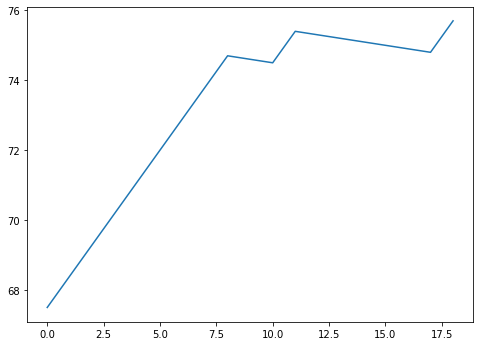

In [68]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8,5.8)


plt.plot(state_seq_[:-1])


In [402]:
x = 4
start_capacity+x*0.8-(19-x)*0.2

67.7004

In [54]:
def pipe(n_samples=30, random=False):

    reward_list = []

    _s_idx = df[df.date == "2022-04-08 10:45:00"].index[0]

    for i in range(n_samples):
        _seq = df[_s_idx:_s_idx+25][["i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]
        _seq.i_m1sum /= 1000
        _seq.power_consumption /= 1000


        rewards, states, tree, f_level_idx = simulate(levels,_seq)
        f_rewards = rewards[f_level_idx:-3]
        b_i = f_rewards.argmax() 
        if random:
            b_i = np.random.choice(np.arange(f_rewards.size))


        reward_list.append(rewards[b_i + f_level_idx])

        _s_idx +=96

    return reward_list


reward_list = pipe()
reward_list_r = pipe(random=True)

0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65535
17 131071
18 262143
0 0
1 1
2 3
3 7
4 15
5 31
6 63
7 127
8 255
9 511
10 1023
11 2047
12 4095
13 8191
14 16383
15 32767
16 65

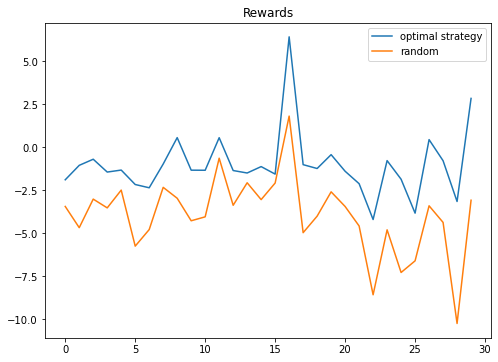

In [70]:
plt.plot(reward_list, label="optimal strategy")
plt.plot(reward_list_r, label="random")
plt.title("Rewards")
plt.legend()
plt.show()

In [ ]:
def simulate_reward_mypv(pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state):
    
    
    if state+kwh_increase > max_storage_tank:
        kwh_increase = max_storage_tank - state
    
    '''
    ! VORZEICHEN DER VARIABLEN !
    '''

    kwh_increase = pv_excess - power_consumption - thermal_consumption  

    if kwh_increase < 0: 
        kwh_increase = 0

    diff = pv_excess - kwh_increase - power_consumption - thermal_consumption    
        
    if diff < 0:
        reward = -(diff * demand_price + (kwh_increase - diff) * feedin_price)
    else:
        reward = -(kwh_increase * feedin_price)  + diff * feedin_price
        
        
    '''
    PENALTY FOR DISTANCE TO OPTIMUM
    '''
    reward -= abs(state - optimum_storage)*gamma
    
    
    return kwh_increase, reward


def pipe_mypv(n_samples=30):

    reward_list = []

    _s_idx = df[df.date == "2022-04-08 10:45:00"].index[0]

    for i in range(n_samples):
        _seq = df[_s_idx:_s_idx+25][["i_m1sum" ,"power_consumption", "thermal_consumption_kwh", "demand_price", "feedin_price", "kwh_eq_state"]]
        _seq.i_m1sum /= 1000
        _seq.power_consumption /= 1000

        reward_ = 0
        for seq_row in _seq:


            pv_excess = seq_row.i_m1sum
            demand_price = seq_row.demand_price
            feedin_price = seq_row.feedin_price
            power_consumption = seq_row.power_consumption
            thermal_consumption = abs(seq_row.thermal_consumption_kwh)
            
            reward_ += simulate_reward_mypv(pv_excess, demand_price, feedin_price, power_consumption, thermal_consumption, state_root)
            

            
            states[r*2 +1] = step(state_root, thermal_consumption, left)

In [42]:
np.ones(2**30)   # 8GB RAM equivalent

array([1., 1., 1., ..., 1., 1., 1.])

https://www.edureka.co/community/18855/numpy-multiplying-large-arrays-with-dtype-int8-is-slow

In [63]:
d = np.ones(2**20, dtype="u1")
print("Memory size of numpy array in MB:",d.size * d.itemsize/1000000)

d = np.ones(2**20, dtype="float32")
print("Memory size of numpy array in MB:",d.size * d.itemsize/1000000, "| Tracked time demo run: 40sec")

d = np.ones(2**20)
print("Memory size of numpy array in MB:",d.size * d.itemsize/1000000, "| Tracked time demo run: 13sec")

Memory size of numpy array in MB: 1.048576
Memory size of numpy array in MB: 4.194304 | Tracked time demo run: 40sec
Memory size of numpy array in MB: 8.388608 | Tracked time demo run: 13sec
